# Estimating the total number of comments on Reddit

In [2]:
# run this code block the very first time to install the necessary dependencies
 using Pkg
 Pkg.instantiate() # remove semicolon to show output

In [3]:
# run this code block to import the necessary packages; the source code for this notebook is available at ./src
 project_dir = dirname(@__DIR__)
 src_dir = project_dir*"/src/"
 data_dir = project_dir*"/datasets/"
 include(src_dir*"RedditSubsampling.jl")
 using DataFrames,CSV,Plots,StatsBase,Printf,.RedditSubsampling
 default(framestyle = :box,legendfontsize = 11,linewidth = 2)

## Import dataset
- Import the distribution of the number of comments per discussions in a community.
- Display the most important summary statistics (mean, median, standard deviation, total number of discussions)
- Plot the ccdf of the distribution

In general: the **distribution of the number of comments per discussions in a reddit community is heavy-tailed** i.e. most discussions are small, a few are extremely large. This is caused by a **rich-get-richer effect**: large discussions attract users by virtue of being already popular; small discussions get forgotten quickly.

Notice how the median is usually much smaller than the mean, which in turn is much smaller than the standard deviation.

number of discussions: 3.26e+05 
total number of comments: 8.86e+06 
 
number of comments per discussion: 
- median: 0.0 
- mean: 27.2 
- standard deviation: 323.4 


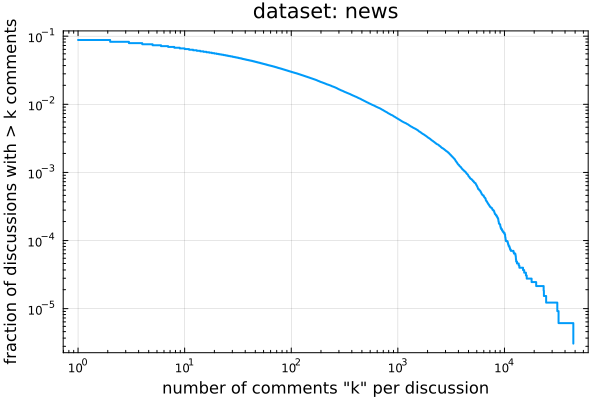

In [4]:
# expand this comment block for the list of datasets available in this demo:
 # - reddit (all the discussions on reddit from 2005 to december 2022)
 # - pareto (a synthetic dataset with 100k samples from a discrete power-law distribution with exponent 1.25)
 # the following datasets include all the discussion in 2022 from a specific community
 # - politics
 # - news
 # - unpopularopinion
 # - conspiracy
 # - casualuk
 # - askreddit
dataset = "news"

# read data
 df = CSV.read(data_dir*dataset*".csv",DataFrame)
 EM = EmpiricalMeasure(df.num_comments,df.frequency)
# print summary statistics
 @printf("number of discussions: %.2e \n",mass(EM))
 @printf("total number of comments: %.2e \n \n",sum(EM))
 @printf("%s \n","number of comments per discussion:")
 @printf("- median: %.1f \n",median(EM))
 @printf("- mean: %.1f \n",mean(EM))
 @printf("- standard deviation: %.1f \n",std(EM))
# plot the probability that a discussion has more than k comments
 total_number_of_comments = sum(EM)
 x,G = ccdf(EM)
 logplot(x,G;line = :steppost,xlabel = "number of comments \"k\" per discussion",ylabel = "fraction of discussions with > k comments",title = "dataset: $dataset",legend = false)

## Estimate the size of a community from a single sample
- Set the sampling probability $p$
- Sample each discussion in the dataset with probability $p$
- Estimate the number of comments in the sample
- Compare with the true number of comments in the entire dataset
- Estimate the precision of the estimate in-sample as described in README.ml (Section 9)

Notice that if $p$ is too small, then we are not able to sample the tail of the distribution adequately. This causes the estimate to be imprecise, as the tail may be overrepresented or underrepresented in the sample.

sampling probability: 1.00e-02 
total discussions: 3.26e+05 
sampled discussions: 3.15e+03 
 
ratio estimated/true number of comments = 1.33 ± 0.30 


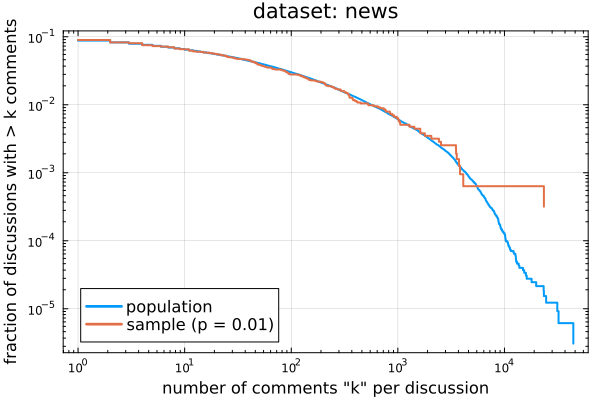

In [5]:
# sampling probability;
# try e.g. p = 1e-2, 5e-2, 1e-1 for individual communities,
# try e.g. p = 1e-6, 1e-5, 1e-4 for the "reddit" dataset
p = 1e-2

# sample each discussion from the community with probability p
 EM_sample = subsample(EM,p)
 estimated_number_of_comments = sum(EM_sample)/p
 ratio = estimated_number_of_comments / total_number_of_comments
 in_sample_error_estimate = norm(EM_sample,2)/sum(EM_sample)
 x_sample,G_sample = ccdf(EM_sample)

# print summary statistics
 @printf("sampling probability: %.2e \n",p)
 @printf("total discussions: %.2e \n",mass(EM))
 @printf("sampled discussions: %.2e \n \n",mass(EM_sample))
 @printf("ratio estimated/true number of comments = %.2f ± %.2f \n",ratio,in_sample_error_estimate)

# plot distribution of population vs sample
 plot(xlabel = "number of comments \"k\" per discussion",ylabel = "fraction of discussions with > k comments",title = "dataset: $dataset",legend = :bottomleft)
 logplot!(x,G;line = :steppost,label = "population")
 logplot!(x_sample,G_sample;line = :steppost,label = "sample (p = $p)")

## Assess the precision of the estimate from $n \gg 1$ independent samples
- Fix a sampling probability $p$
- Generate $n$ independent samples from the dataset
- Estimate the total number of comments from each sample
- Compute mean, standard deviation, median, upper and lower quartiles
- Plot the distribution of the estimate

Denote by $r$ the ratio between the estimated and the true number of comments. Notice that if $p$ is too small, then the distribution of $r$ shows strong deviations from normality. This is due to the heavy tails in the distribution of the number of comments per discussion.

The deviations from normality are particularly visible in the qq-plot comparing the quantiles of $r$ with the quantiles of a normal distribution with the same mean and variance as $r$.

sampling probability: 1.00e-02 
total no. of discussions: 3.26e+05 
expected no. of sampled discussions: 3.26e+03 
 
ratio estimated/true number of comments: 
mean ± standard deviation: 1.00 ± 0.21 
median ± interquartile range: 0.98 ± 0.27 


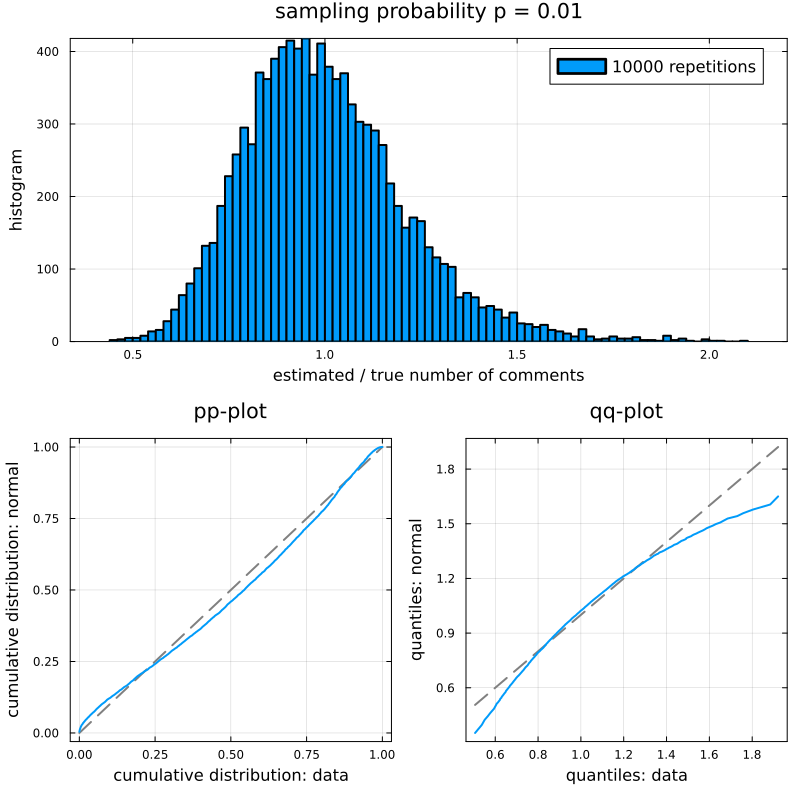

In [10]:
p = 1e-2  # try for example p=1e-1, p=1e-2, p=1e-3 for individual subreddits, and p = 1e-4, p = 1e-5, p = 1e-6 for the "reddit" dataset
n_independent_samples = 10_000

estimated_number_of_comments = subsampledsum(EM,p,n_independent_samples;rescale = true)
r = estimated_number_of_comments/total_number_of_comments

# print summary statistics
 @printf("sampling probability: %.2e \n",p)
 @printf("total no. of discussions: %.2e \n",mass(EM))
 @printf("expected no. of sampled discussions: %.2e \n \n",p*mass(EM))

 @printf("%s \n","ratio estimated/true number of comments:")
 @printf("mean ± standard deviation: %.2f ± %.2f \n",mean(r),std(r))
 @printf("median ± interquartile range: %.2f ± %.2f \n",median(r),iqr(r))

# plot histogram, pp-plot, qq-plot of the ratio between estimated and true number of comments
 fig1 = histogram(r;bins = 100,xlabel = "estimated / true number of comments",ylabel = "histogram",label = "$n_independent_samples repetitions",title = "sampling probability p = $p")
 fig2 = pp_plot(r;title = "pp-plot")
 fig3 = qq_plot(r;title = "qq-plot")
 layout = @layout([a; b c])
 fig = plot(fig1, fig2, fig3, layout=layout, size=(800, 800))

## Assess the precision of the estimate as a function of the sampling probability
- Fix a range of sampling probabilities
- Obtain several independent samples from the dataset for each $p$
- Compute the precision of the estimate for each $p$ as the standard deviation / iterquartile range over all samples.

As described in README.ml (Sections 4-5) the precision of the estimate scales as $p^{-1/2}$ and the scaling constant depends on how heavy-tailed is the distribution of the number of comments per discussion.

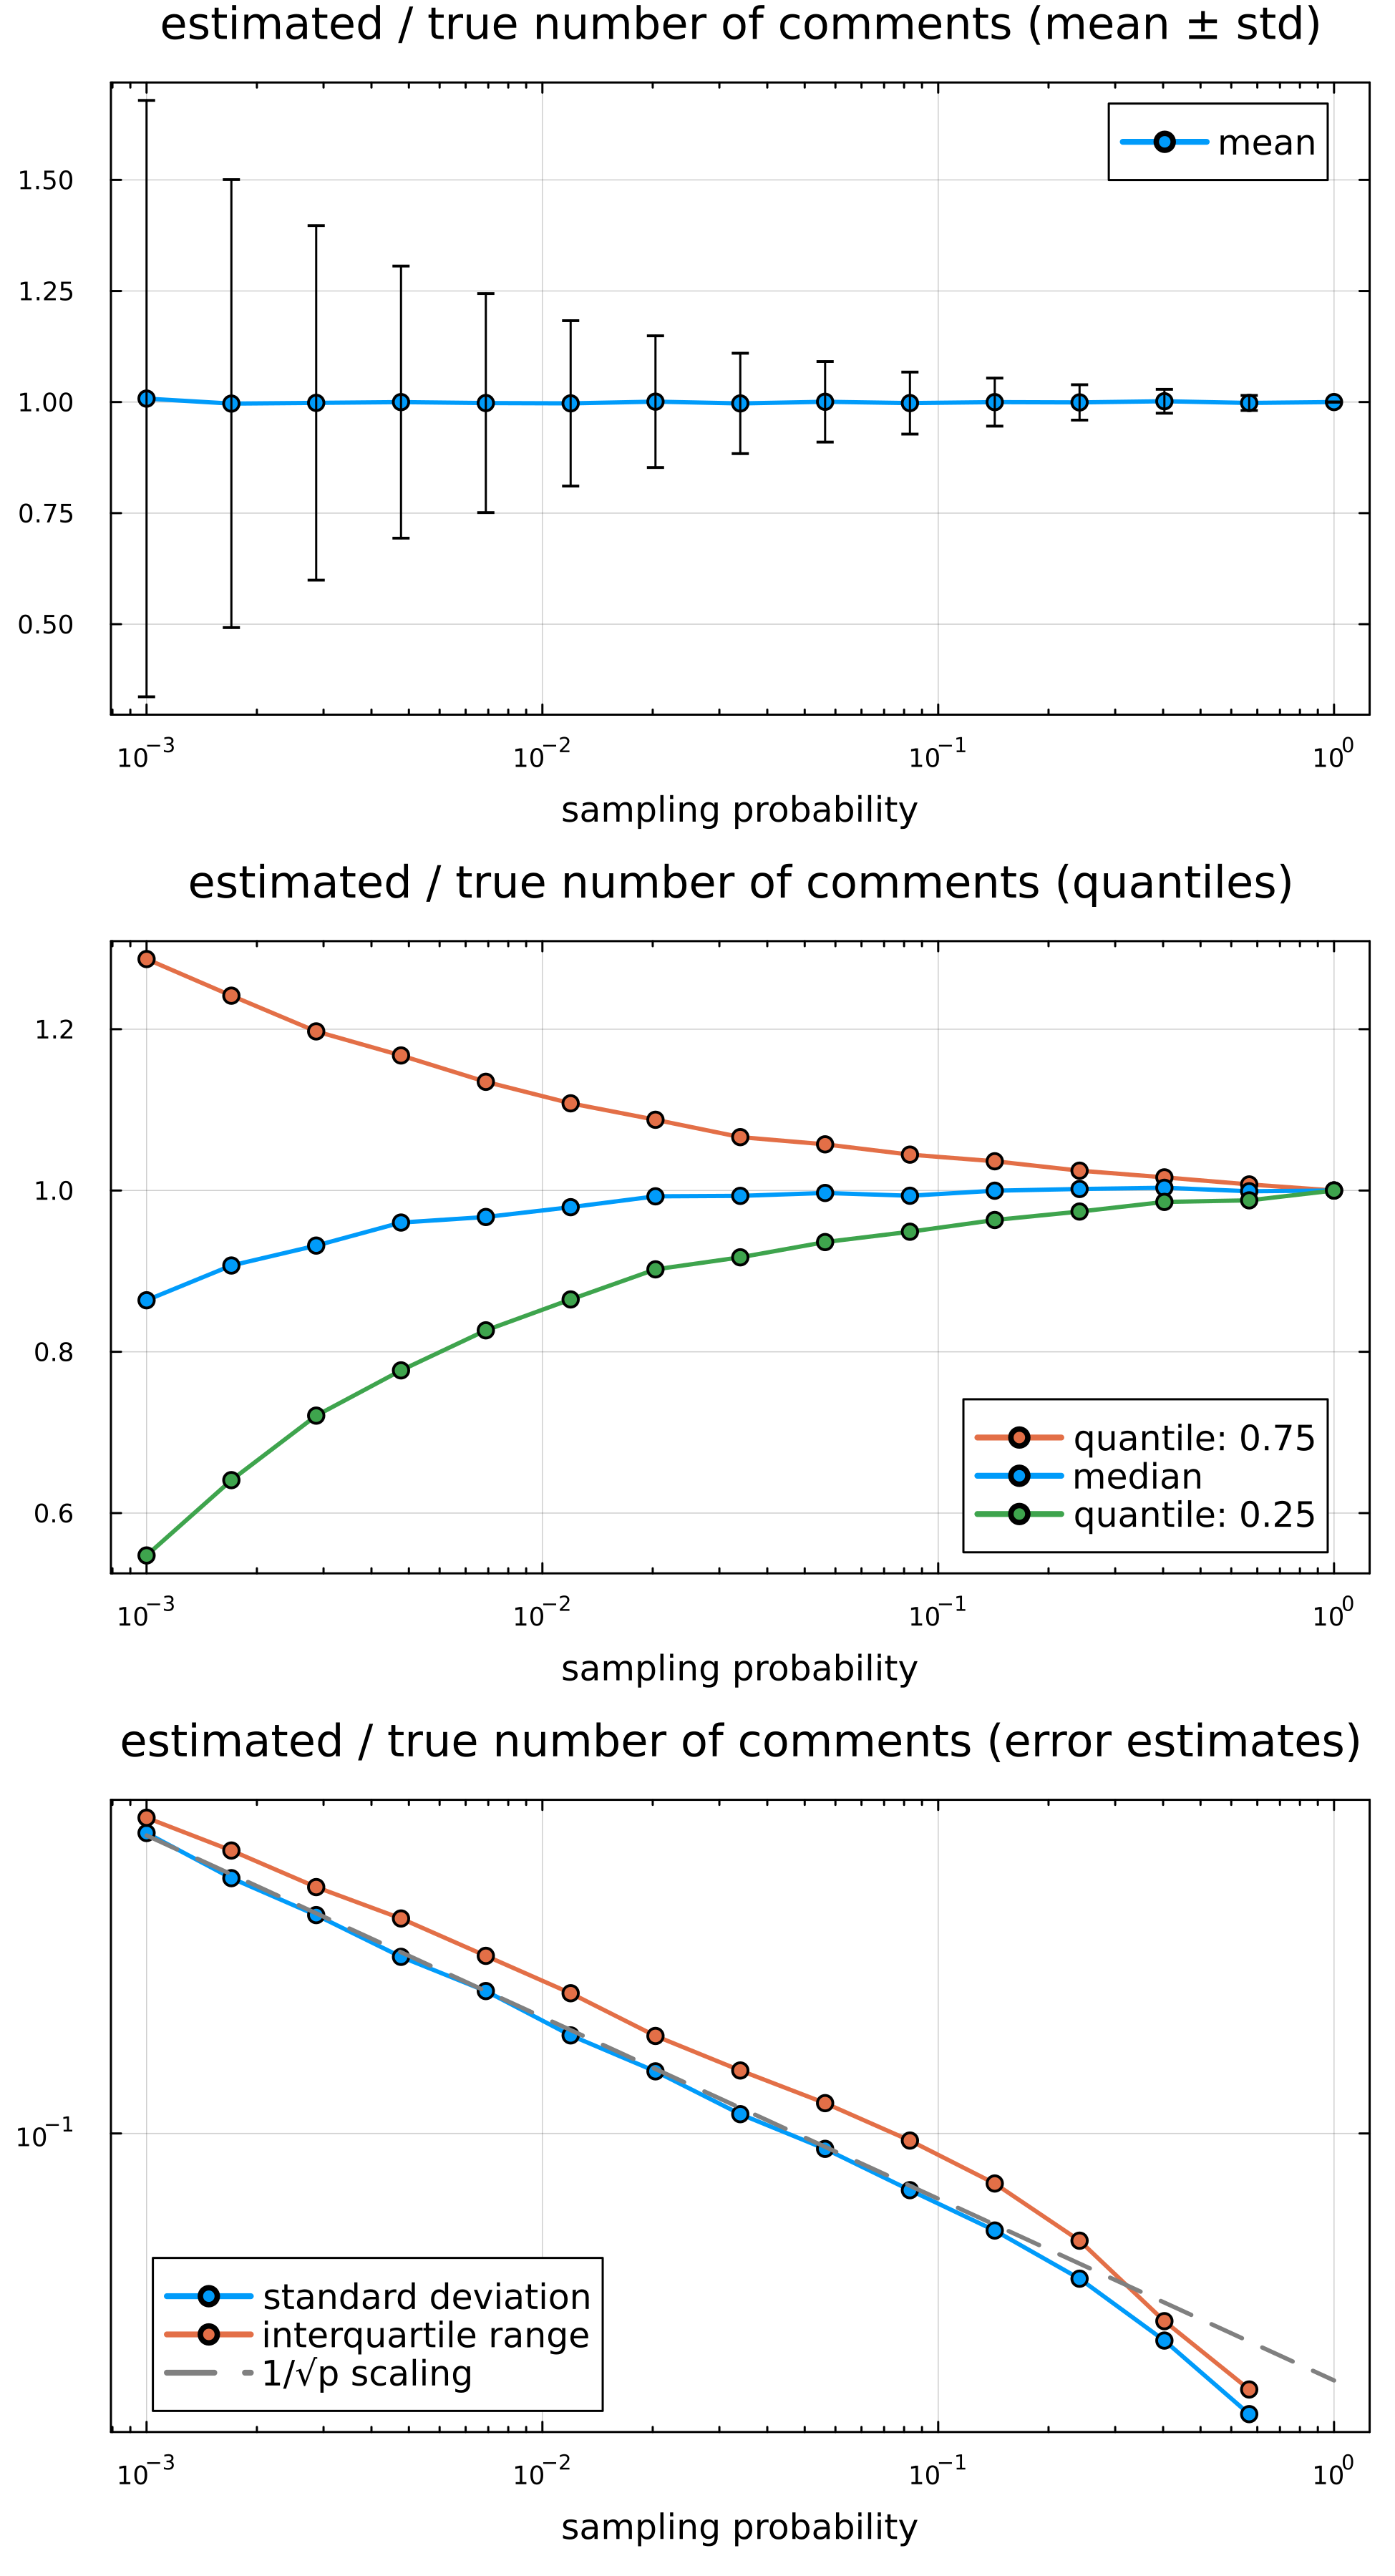

In [7]:
p_min = 1e-3 # use e.g. 1e-3 for individual communities, 1e-6 for the entire reddit dataset
p_max = 1e-0 # use e.g. 1 for individual communities, 1e-2 for the entire reddit dataset
n_parameters = 15 # number of values of p between p_min and p_max

p_range = logspace(p_min,p_max,n_parameters)
n_test = logspace(10_000,100.0,n_parameters) .|> ceil .|> Int64 # reduce the number of tests as the sampling probability increases
functionals = (mean,std,median,quantile25,quantile75)
c = norm(EM,2)/sum(EM) # scaling constant for the variance of r

# run a parameter scan
 f(EM,p) = subsampledsum(EM,p;rescale = true)/sum(EM)
 means,standard_deviations,medians,quantiles25,quantiles75 = parameter_scan(f,EM,p_range,n_test,functionals)
# then plot the results
 fig1 = plot(title = "estimated / true number of comments (mean ± std)",xlabel = "sampling probability")
 fig1 = xsemilogplot!(p_range,means,yerr = standard_deviations,marker = :circle,label = "mean")

 fig2 = plot(title = "estimated / true number of comments (quantiles)",xlabel = "sampling probability",legend = :bottomright)
 fig2 = xsemilogplot!(p_range,quantiles75,label = "quantile: 0.75",color = 2,marker = :circle)
 fig2 = xsemilogplot!(p_range,medians,label = "median",color = 1,marker = :circle)
 fig2 = xsemilogplot!(p_range,quantiles25,label = "quantile: 0.25",color = 3,marker = :circle)
 
 fig3 = plot(title = "estimated / true number of comments (error estimates)",xlabel = "sampling probability",legend = :bottomleft)
 fig3 = logplot!(p_range,standard_deviations,label = "standard deviation",marker = :circle)
 fig3 = logplot!(p_range,quantiles75-quantiles25,label = "interquartile range",marker = :circle)
 fig3 = logplot!(p_range,c*(p_range).^(-0.5),label = "1/√p scaling",color = :gray,line = :dash,alpha = 1)

 layout = @layout([a;b;c])
 plot(fig1, fig2, fig3, layout=layout, size=(650, 1200),left_margin=5Plots.mm,dpi = (300))
 

## Assess the in-sample approximation for the standard error
- Fix a range of sampling probabilities
- Obtain several independent samples from the dataset for each $p$
- Compute the in-sample error approximation for each sample, as described in README.md (Section 9)
- Compute mean, standard deviation and compare with exact result.

In general, the in-sample approximation tends to underestimate the error If the sampling probability p is very small. But the approximation is not too bad for small, but not too small, values of $p$.

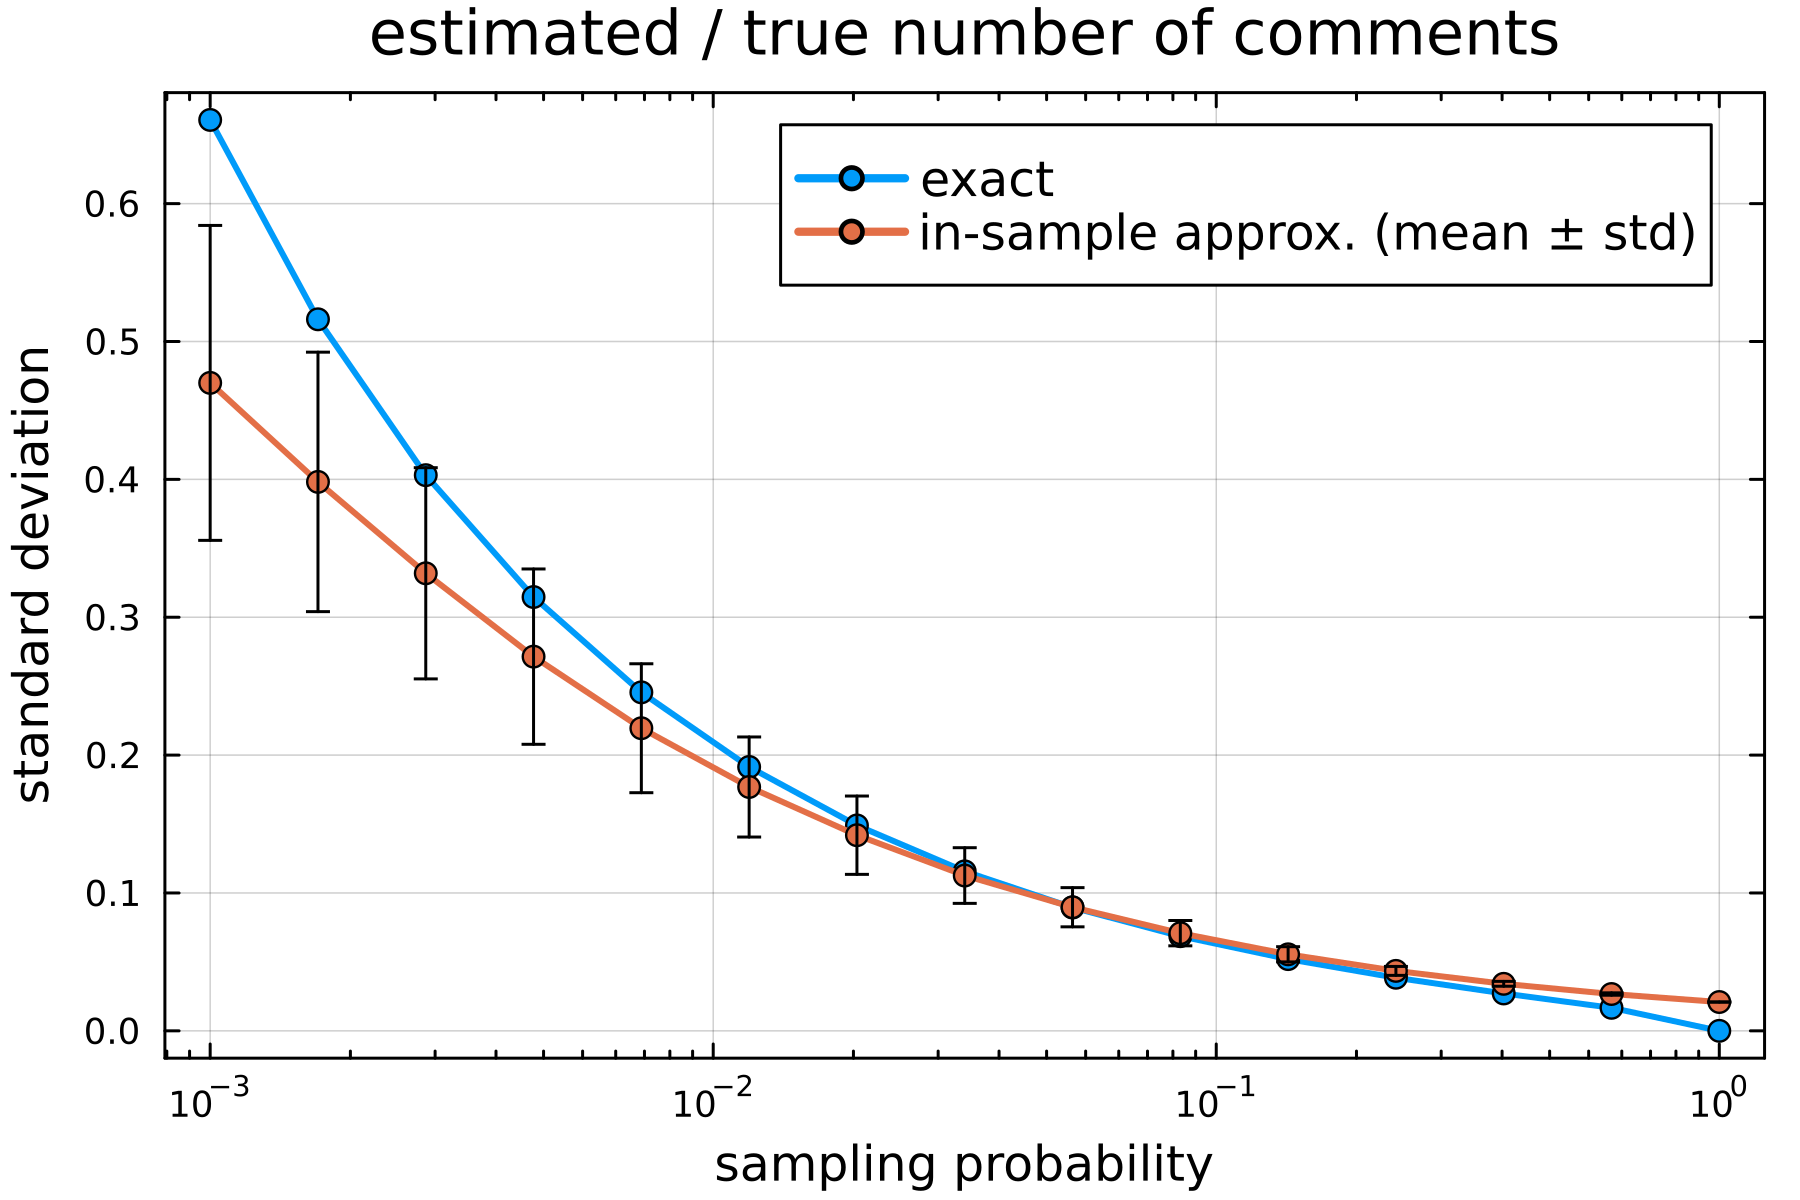

In [9]:
p_min = 1e-3 # use e.g. 1e-3 for individual communities, 1e-6 for the entire reddit dataset
p_max = 1e-0 # use e.g. 1 for individual communities, 1e-2 for the entire reddit dataset
n_parameters = 15 # number of values of p between p_min and p_max


p_range = logspace(p_min,p_max,n_parameters)
n_test = logspace(10_000,100.0,n_parameters) .|> ceil .|> Int64 # reduce the number of tests as the sampling probability increases
# run a parameter scan
 function f(EM,p)
     EM_sub = subsample(EM,p)
     return norm(EM_sub,2)/sum(EM_sub)
 end
 means,errors = parameter_scan(f,EM,p_range,n_test,(mean,std))
 scaling_constant = norm(EM,2)/sum(EM)
# plot the results
 plot(xlabel = "sampling probability",ylabel = "standard deviation",dpi = 300,title = "estimated / true number of comments")
 xsemilogplot!(p_range,scaling_constant*(@. sqrt(1/p_range - 1)),label = "exact",marker = :circle)
 xsemilogplot!(p_range,means;yerr=errors,label = "in-sample approx. (mean ± std)",marker = :circle)
